## NLP From Scratch: Classifying Names with a Character-Level RNN

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

In [5]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the Network

In [26]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [27]:
input = letterToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8524, -2.9285, -2.8883, -2.8557, -2.8618, -2.8911, -2.8382, -2.7820,
         -2.9498, -3.0294, -2.7828, -2.8831, -3.0153, -2.8662, -2.9393, -2.9510,
         -2.8945, -2.8557]], grad_fn=<LogSoftmaxBackward>)


## Training

### Prepare Training

In [28]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 7)


In [29]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f"Category = {category} / Line = {line}")

Category = Vietnamese / Line = Thuy
Category = Irish / Line = Riain
Category = French / Line = Paris
Category = Irish / Line = Sluaghadhan
Category = French / Line = Abel
Category = Chinese / Line = Xin
Category = Japanese / Line = Yamaguchi
Category = Japanese / Line = Ijiri
Category = Korean / Line = Yang
Category = Korean / Line = Jung 


### Training the Network

In [30]:
criterion = nn.NLLLoss()

In [31]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [32]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m:.0f}m {s:.0f}s"

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else f'✗ {category}'
        print(f"{iter} {iter/n_iters * 100}% {timeSince(start)} {loss:.4f} {line} {guess} {correct}")
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0% 0m 9s 2.8685 Chmiel German ✗ Polish
10000 10.0% 0m 17s 1.9001 Totah Arabic ✓
15000 15.0% 0m 26s 3.4717 Conn Chinese ✗ Irish
20000 20.0% 0m 35s 2.1341 Pillar Scottish ✗ Czech
25000 25.0% 0m 45s 2.0739 Medina Italian ✗ Spanish
30000 30.0% 0m 55s 0.6150 Chu Vietnamese ✓
35000 35.0% 1m 5s 2.3155 Reid French ✗ Scottish
40000 40.0% 1m 15s 4.2122 Jernovoy French ✗ Russian
45000 45.0% 1m 24s 0.5649 Gwozdek Polish ✓
50000 50.0% 1m 32s 1.0536 Schneiders Dutch ✓
55000 55.00000000000001% 1m 41s 4.2879 Lamon English ✗ Italian
60000 60.0% 1m 49s 1.2842 Fraser Scottish ✓
65000 65.0% 1m 58s 0.0519 Koulaxizis Greek ✓
70000 70.0% 2m 6s 0.2438 Miyahara Japanese ✓
75000 75.0% 2m 15s 0.2355 Yan Chinese ✓
80000 80.0% 2m 23s 3.0033 Rosenfeld English ✗ German
85000 85.0% 2m 32s 0.5811 Tuma Arabic ✓
90000 90.0% 2m 40s 0.5289 Schultz German ✓
95000 95.0% 2m 49s 0.3186 Roijakkers Dutch ✓
100000 100.0% 2m 57s 0.6911 Vandroogenbroeck Dutch ✓


### Plotting the Results

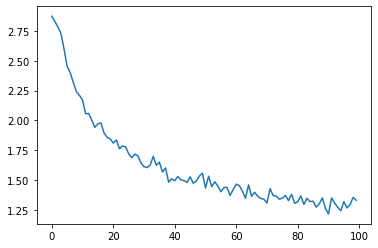

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### Evaluating the Results

<ipython-input-34-ce4afcf74f79>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-34-ce4afcf74f79>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


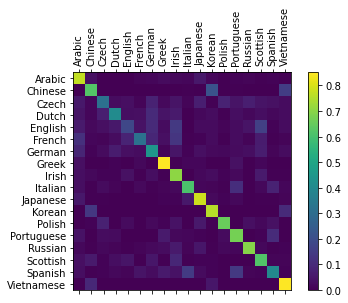

In [34]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Running on User Input

In [36]:
def predict(input_line, n_predictions=3):
    print(f"> {input_line}")
    
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f"{value:.2f} {all_categories[category_index]}")
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Yoo')

> Dovesky
-0.79 Czech
-1.05 Russian
-2.20 English
> Jackson
-0.32 Scottish
-2.24 Russian
-2.39 English
> Yoo
-0.26 Korean
-1.51 Chinese
-5.30 Vietnamese
